# Imports, setting up device and seeds

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# torch.cuda.set_device(1)
# device = torch.device("cuda")
# device = torch.device('mps')
device = torch.device('mps')

In [3]:
# torch.manual_seed(42)


import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Constants

In [4]:
GOOGLE_COLAB_VERSION = False
VALIDATION_PERCENTAGE = 0.10    # TODO: change to 0.06
TRAIN_PATH = "./train"
TEST_PATH = "./test_all"

# Get and transform data

In [5]:
import random


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.std = std
        self.mean = mean
        self.prob = p
        
    def __call__(self, tensor):
        if random.random() < self.prob:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        return tensor
    
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [6]:
# # calculate mean and standard deviation for Normalize()
# def get_mean_and_std(dataloader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in dataloader:
#         # Mean over batch, height and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1
    
#     mean = channels_sum / num_batches

#     # std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

#     return mean, std


# dataFolder_before_transform = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transforms.Compose([transforms.ToTensor()]))
# mean_for_normalize, std_for_normalize = get_mean_and_std(torch.utils.data.DataLoader(dataFolder_before_transform, batch_size=256))

# uncomment above in order to calculate values below (takes around 20 seconds)
mean_for_normalize = [0.5204, 0.4950, 0.4381]
std_for_normalize = [0.2846, 0.2773, 0.2980]

In [7]:
print(mean_for_normalize, std_for_normalize)

[0.5204, 0.495, 0.4381] [0.2846, 0.2773, 0.298]


In [8]:
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
    #  transforms.ColorJitter()
     transforms.ToTensor(),
     AddGaussianNoise(0.1, 0.08),
     transforms.RandomErasing(0.4),
     transforms.Normalize(mean_for_normalize, std_for_normalize)])

transform_val = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean_for_normalize, std_for_normalize)])

trainFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_train)

valFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_val)

# valFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_val)

# trainloader = torch.utils.data.DataLoader(trainFolder, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root=TEST_PATH, train=False,
#                                        download=False, transform=transform)

# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

In [9]:
# split into train and validation
train_size = int((1 - VALIDATION_PERCENTAGE) * len(trainFolder))
val_size = len(trainFolder) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainFolder, [train_size, val_size])

# prepare validation data without augmentation
val_subset_without_augmentation = torch.utils.data.Subset(valFolder, val_subset.indices)
val_loader_without_augmentation = torch.utils.data.DataLoader(val_subset_without_augmentation, batch_size=32, shuffle=True)

## Example images

In [10]:
train_loader_for_imshow = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader_for_imshow = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


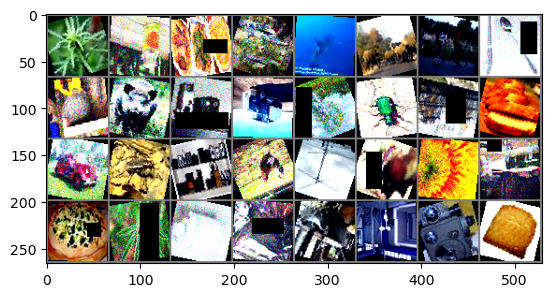

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(train_loader_for_imshow))
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


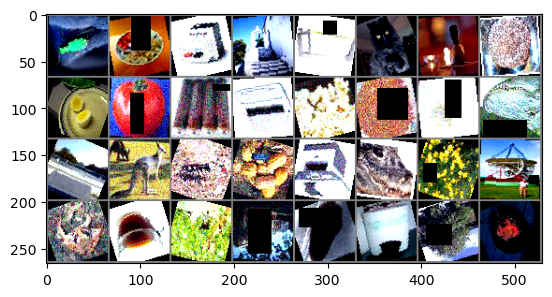

In [12]:
images, labels = next(iter(val_loader_for_imshow))
imshow(torchvision.utils.make_grid(images))

## Visualize data distribution

In [13]:
list(trainFolder.class_to_idx.values())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

<BarContainer object of 50 artists>

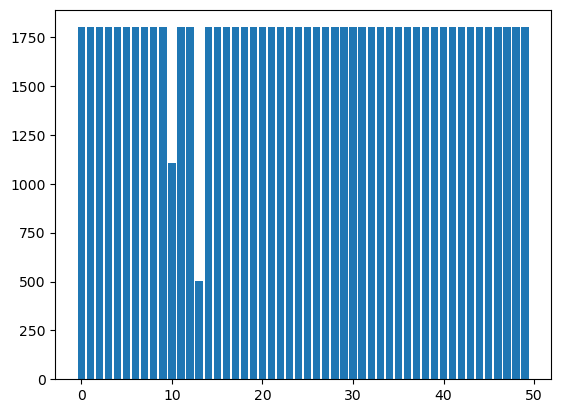

In [14]:
plt.bar(*np.unique(trainFolder.targets, return_counts=True))

<BarContainer object of 50 artists>

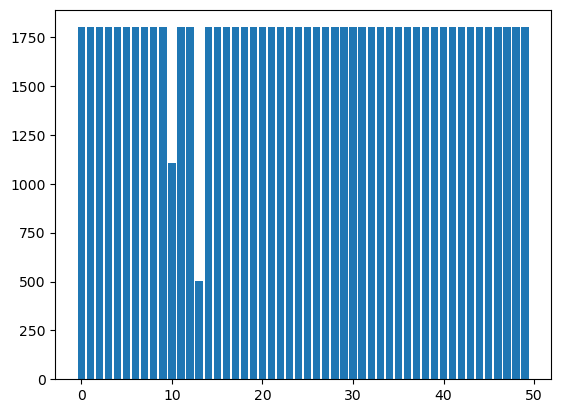

In [15]:
plt.bar(*np.unique(val_subset.dataset.targets, return_counts=True))

### Compute class weights for above data distribution

In [16]:
from sklearn.utils.class_weight import compute_class_weight


CLASS_WEIGHT= compute_class_weight(class_weight='balanced', classes=list(trainFolder.class_to_idx.values()), y=trainFolder.targets)
classes_weights = torch.tensor(np.array(CLASS_WEIGHT).astype('float32')).to(device)

In [17]:
for class_idx, class_weight in zip(trainFolder.class_to_idx.values(), CLASS_WEIGHT):
    print(class_idx, class_weight)

# ponizej widzimy, ze indexy zgadzają sie z powyzszym wykresem (mniej przykładów dla 10 i 13)

0 0.9779
1 0.9779
2 0.9779
3 0.9779
4 0.9779
5 0.9779
6 0.9779
7 0.9779
8 0.9779
9 0.9779
10 1.5886462093862816
11 0.9779
12 0.9779
13 3.4994433399602385
14 0.9779
15 0.9779
16 0.9779
17 0.9779
18 0.9779
19 0.9779
20 0.9779
21 0.9779
22 0.9779
23 0.9779
24 0.9779
25 0.9779
26 0.9779
27 0.9779
28 0.9779
29 0.9779
30 0.9779
31 0.9779
32 0.9779
33 0.9779
34 0.9779
35 0.9779
36 0.9779
37 0.9779
38 0.9779
39 0.9779
40 0.9779
41 0.9779
42 0.9779
43 0.9779
44 0.9779
45 0.9779
46 0.9779
47 0.9779
48 0.9779
49 0.9779


## More data information

In [18]:
len(train_subset.indices)

79209

In [19]:
len(val_subset.indices)

8802

In [20]:
val_subset_data = [trainFolder[i] for i in val_subset.indices]
val_subset_data

[(tensor([[[-1.8285, -1.0569, -1.0569,  ..., -1.8285, -1.8285, -1.8285],
           [-1.8285, -1.0707, -1.0845,  ..., -1.2360, -1.2498, -1.2498],
           [-1.8285, -1.1120, -1.1120,  ..., -1.2774, -1.2774, -1.2774],
           ...,
           [-1.0707, -1.0569, -1.0569,  ..., -1.4152, -1.3876, -1.8285],
           [-1.0293, -1.0431, -1.0293,  ..., -1.4014, -1.3738, -1.8285],
           [-1.8285, -1.8285, -1.8285,  ..., -1.4014, -1.3738, -1.8285]],
  
          [[-1.7851, -0.4699, -0.4699,  ..., -1.7851, -1.7851, -1.7851],
           [-1.7851, -0.4840, -0.4699,  ..., -0.1587, -0.1446, -0.1446],
           [-1.7851, -0.4982, -0.4982,  ..., -0.1870, -0.1870, -0.1729],
           ...,
           [-0.2295, -0.2436, -0.2436,  ..., -0.9790, -0.9931, -1.7851],
           [-0.1870, -0.2012, -0.2153,  ..., -1.0073, -0.9931, -1.7851],
           [-1.7851, -1.7851, -1.7851,  ..., -1.0214, -1.0355, -1.7851]],
  
          [[-1.4701, -0.7858, -0.7858,  ..., -1.4701, -1.4701, -1.4701],
           

In [21]:
# create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=256) # TODO: change to max, który się szybko liczy

In [22]:
test_batch = next(iter(train_dataloader))

In [23]:
test_batch[0].shape

torch.Size([32, 3, 64, 64])

# Model

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)    # TODO: try to remove this relu, # TODO: compare bias=False and True
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 50):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        # self.avgpool = nn.AvgPool2d(2, stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        # print(x.shape)
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [25]:
# import torch

# n_channels_test = 64
# input_test = torch.rand(32, 3, 32, 32)

# conv1_test = torch.nn.Conv2d(in_channels=3, out_channels=n_channels_test, kernel_size=3, stride=1, padding=1)
# x_test = conv1_test(input_test)
# print(x_test.shape)

# conv2_test = nn.Conv2d(in_channels=n_channels_test, out_channels=n_channels_test, kernel_size=3, stride=1, padding=1)
# x_test = conv2_test(x_test)
# print(x_test.shape)

# conv3_test = ConvBlock(in_channels=n_channels_test)
# x_test = conv3_test(x_test)
# print(x_test.shape)

In [26]:
import torchvision.models as models

# net = Net().to(device)
# net = models.resnet18().to(device)
# net = models.densenet161().to(device)
# net = Net().to(device)
net = ResNet(ResidualBlock, [3, 2, 3, 2]).to(device)
net

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [27]:
# # compare achitectures:
# with open('architecture_ResNet_implemented.txt', 'w') as f:
#     print(net, file=f)  # Python 3.x

# with open('architecture_resnet18.txt', 'w') as f:
#     print(models.resnet18().to(device), file=f)  # Python 3.x

In [28]:
print(test_batch)
print(type(test_batch))
print(len(test_batch))

[tensor([[[[-1.8285, -1.8285, -1.8285,  ...,  0.2521,  0.3072, -1.8285],
          [ 0.2384,  0.2108,  0.1557,  ...,  0.2108,  0.1143, -1.8285],
          [ 0.1695,  0.1695,  0.1143,  ...,  0.2246,  0.0868, -1.8285],
          ...,
          [-1.8285,  0.6104,  0.5691,  ...,  0.5002,  0.7757,  1.0238],
          [-1.8285,  0.4864,  0.4313,  ...,  0.5553,  0.7620,  0.8722],
          [-1.8285,  0.3899,  0.3486,  ..., -1.8285, -1.8285, -1.8285]],

         [[-1.7851, -1.7851, -1.7851,  ...,  0.3645,  0.4211, -1.7851],
          [ 0.3645,  0.3362,  0.2797,  ...,  0.3221,  0.2231, -1.7851],
          [ 0.2938,  0.2938,  0.2372,  ...,  0.3362,  0.1948, -1.7851],
          ...,
          [-1.7851,  0.9160,  0.8736,  ...,  0.6756,  0.9585,  1.2130],
          [-1.7851,  0.8312,  0.7746,  ...,  0.7888,  1.0009,  1.1140],
          [-1.7851,  0.7322,  0.6898,  ..., -1.7851, -1.7851, -1.7851]],

         [[-1.4701, -1.4701, -1.4701,  ...,  0.4643,  0.5170, -1.4701],
          [ 0.5170,  0.4907, 

In [29]:
# from torchviz import make_dot
# from datetime import datetime

# # uncomment this cell to visualize a net (do it on the cpu - change device from 'mps' to 'cpu')
# yhat = net(test_batch[0])
# current_datetime_formatted = f'{datetime.now()}'.replace('-', '_').replace(' ', '_').replace(':', '_')[:-4]
# make_dot(yhat, params=dict(list(net.named_parameters()))).render(f"net_visualizations/net_visualization{current_datetime_formatted}", format="png")

In [30]:
def number_of_parameters(net=models.resnet18()):
    params_sum = 0
    for params in net.parameters():
        params_sum+=params.view(-1).size(0)
    return params_sum

In [31]:
# number of parameters in Net - compare to resnet18
print(f'number of parameters in created net = {number_of_parameters(net=net)}')
print(f'number of parameters in resnet18    = {number_of_parameters()}')

number of parameters in created net = 6189618
number of parameters in resnet18    = 11689512


## Additional functions

In [32]:
def plot_results(epochs, losses, train_acc, val_acc):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [33]:
def get_accuracy(val_dataloader=val_dataloader):    # TODO: accuracy per klasa
    # copy and create new get_accuracy() func - per class
    val_correct_count = 0
    val_data_len = 0
    
    with torch.no_grad():

        for i, data in enumerate(val_dataloader, 0):
            net.eval()
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            outputs = net(inputs)

            outputs_for_val_correct_count = outputs.max(1, keepdim=True)[1].squeeze()
            val_correct_count += (outputs_for_val_correct_count == labels).sum()
            val_data_len += len(labels)

        new_val_acc = val_correct_count / val_data_len
        return new_val_acc

In [34]:
def get_accuracy_per_class(model=net, loader=val_dataloader, classes=trainFolder.classes):

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    acurracy_sum = 0

    # again no gradients needed
    with torch.no_grad():
        for data in loader:
            images, labels = data    
            images = images.to(device)
            outputs = net(images).cpu()   
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        # print("Accuracy for class {:5s} is: {:.2f} %".format(classname, 
        #                                                accuracy))
        acurracy_sum += accuracy
        
    # print("Average accuracy for a class is: {:.2f} %".format(acurracy_sum/len(classes)))
    
    # division by 100
    return acurracy_sum/(len(classes) * 100)

In [35]:
# from sklearn.metrics import classification_report


# # multi-batch version
# def print_classification_report(val_dataloader=val_dataloader):    
#     with torch.no_grad():
#         all_outputs = torch.empty((len(val_dataloader.dataset.indices), len(val_dataloader.dataset.dataset.classes))).to(device)
#         all_labels = torch.empty(len(val_dataloader.dataset.indices)).to(device)
#         print(len(all_labels))
#         print(all_outputs.shape)
#         for i, data in enumerate(val_dataloader, 0):
#             net.eval()
            
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             # forward + backward + optimize
#             outputs = net(inputs)

#             torch.cat((all_outputs, outputs), 0)
#             torch.cat((all_labels, labels), 0)
#         all_outputs = all_outputs.max(1)[1]
#         print(all_outputs)
#         print(all_outputs.shape)
#         print("aasdf::")
#         print(all_labels)
#         print(all_labels.shape)
#         print(classification_report(all_outputs.cpu(), all_labels.float().cpu()))

In [36]:
from sklearn.metrics import classification_report


# single-batch version
def print_classification_report(val_subset=val_subset):
    with torch.no_grad():
        val_dataloader_big = torch.utils.data.DataLoader(val_subset, batch_size=len(val_subset))
        data = next(iter(val_dataloader_big))
        net.eval()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.max(1)[1]
        print(outputs)
        print(outputs.shape)
        print("aasdf::")
        print(labels)
        print(labels.shape)
        print(classification_report(outputs.cpu(), labels.float().cpu()))
        del data, inputs, labels, outputs

## Net training

In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=classes_weights)     # wazenie przykładów
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-8)   # TODO: try to add very small weight_decay
# optimizer = optim.Adam(net.parameters(), lr=0.01)

In [57]:
%%time

epochs, losses, train_acc, val_acc = [], [], [], []

NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS): 
    train_correct_count = 0
    train_data_len = 0
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # print(i)
        net.train()
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        outputs_for_train_correct_count = outputs.max(1, keepdim=True)[1].squeeze()
        train_correct_count += (outputs_for_train_correct_count == labels).sum()
        train_data_len += len(labels)

        # # clear memory
        # del inputs, labels, outputs
        # torch.mps.empty_cache()

        running_loss_single_iter = loss.item()
        running_loss += running_loss_single_iter

    new_train_acc = train_correct_count / train_data_len
    train_acc.append(new_train_acc)
    
    running_loss /= 1000
    losses.append(running_loss)
    new_val_acc = get_accuracy()
    val_acc.append(new_val_acc)
    epochs.append(epoch+1)

    print(f'epoch {epoch+1} train running accuracy = {new_train_acc}, val_accuracy = {new_val_acc}')
    print(f'[{epoch+1}/{NUM_EPOCHS}] running loss: {round(running_loss, 4)}, macro avg accuracy: {round(get_accuracy_per_class(), 4)}')
    print(f'val accuracy on data without augmentation = {get_accuracy_per_class(loader=val_loader_without_augmentation)}\n')
    running_loss = 0.0

print('Finished Training')

epoch 1 train running accuracy = 0.777916669845581, val_accuracy = 0.5398772954940796
[1/50] running loss: 1.7897, macro avg accuracy: 0.5403
val accuracy on data without augmentation = 0.5818588267116137

epoch 2 train running accuracy = 0.782448947429657, val_accuracy = 0.5436264276504517
[2/50] running loss: 1.7687, macro avg accuracy: 0.5348
val accuracy on data without augmentation = 0.5785088378498988

epoch 3 train running accuracy = 0.781590461730957, val_accuracy = 0.5443081259727478
[3/50] running loss: 1.7684, macro avg accuracy: 0.5434
val accuracy on data without augmentation = 0.577693008906655

epoch 4 train running accuracy = 0.7801638841629028, val_accuracy = 0.5381731390953064
[4/50] running loss: 1.7698, macro avg accuracy: 0.5433
val accuracy on data without augmentation = 0.5751107854007177

epoch 5 train running accuracy = 0.7830296754837036, val_accuracy = 0.5395364761352539
[5/50] running loss: 1.7627, macro avg accuracy: 0.5417
val accuracy on data without augm

In [58]:
print(f'validation accuracy = {get_accuracy()}')

validation accuracy = 0.5428311824798584


In [59]:
get_accuracy_per_class()

0.5415246655090284

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5784342365961581


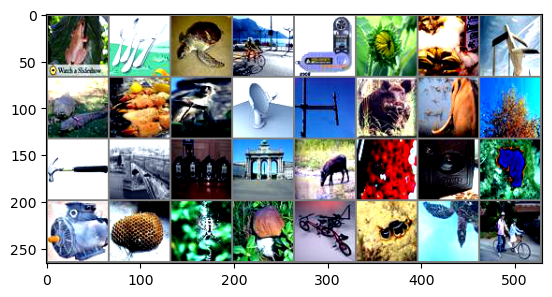

In [65]:
# print score on validation data without augmentation
# valFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_val)
# val_subset_without_augmentation = torch.utils.data.Subset(valFolder, val_subset.indices)
# val_loader_without_augmentation = torch.utils.data.DataLoader(val_subset_without_augmentation, batch_size=32, shuffle=True)
accuracy_without_augmentation = get_accuracy_per_class(loader=val_loader_without_augmentation)
print(accuracy_without_augmentation)
images, labels = next(iter(val_loader_without_augmentation))
imshow(torchvision.utils.make_grid(images))
# print(get_accuracy(val_dataloader=val_loader_without_augmentation))

In [61]:
# TODO: plot loss and accuracy

In [62]:
PRINT_REPORT = False

if PRINT_REPORT:
    print_classification_report()

# Saving model to file

In [67]:
# saving model to file
from datetime import datetime


state_dict = net.state_dict()
current_datetime_formatted = f'{datetime.now()}'.replace('-', '_').replace(' ', '_').replace(':', '_')[:-4]
torch.save(state_dict, f"neural_net{current_datetime_formatted}_acc_{accuracy_without_augmentation}.tar")

# Test predictions

In [87]:
# reading file names (adjust path)
test_files_names = os.listdir(TEST_PATH + "/test_all")

In [88]:
testFolder = torchvision.datasets.ImageFolder(root=TEST_PATH,
                                               transform=transform_val)

testloader = torch.utils.data.DataLoader(testFolder, batch_size=1,
                                         shuffle=False)

In [89]:
preds = []

In [90]:
%%time
for i, data in enumerate(testloader, 0):
    x, labels = data
    # true_values.append(labels)
    x, labels = x.to(device), labels.to(device)
    preds.append(net(x).max(1, keepdim=True)[1].item())

CPU times: user 49.9 s, sys: 9.14 s, total: 59 s
Wall time: 1min 22s


In [91]:
# saving to file
preds_filename = f"preds{current_datetime_formatted}_acc_{accuracy_without_augmentation}.csv"
pd.DataFrame({'A': test_files_names, 'B': preds}).to_csv(preds_filename, index=False, header=False)

In [92]:
pd.read_csv(preds_filename, header=None)

,0,1
0,8885116932060749.JPEG,26
1,9040528456606877.JPEG,31
2,6501173720479193.JPEG,46
3,6466322132242255.JPEG,39
4,8926758762754503.JPEG,45
...,...,...
9995,05423695111982274.JPEG,12
9996,34890558640617564.JPEG,25
9997,11083798003819756.JPEG,31
9998,5568873749583029.JPEG,35
